Here we are interested in Gibbs sampling for normal linear regression with one independent variable. We assume
\begin{align}
y_n \sim \mathcal{N}(\beta_0+\beta_1 x_n, 1/\tau)
\end{align}

where
- $\beta_0 \sim \mathcal{N}(\mu_0, 1/\tau_0)$
- $\beta_1 \sim \mathcal{N}(\mu_1, 1/\tau_1)$
- $\tau \sim \text{Gamma}(\alpha, \delta)$

Given true values $\beta_0 = -1$, $\beta_1=2$ and $\tau = 1$, Gibbs sampling using sequentially updated equations converges to the true value.

The likelihood function is
\begin{align}
\prod_{n=1}^{N} \mathcal{N}(\beta_0+\beta_1 x_n, 1/\tau)
\end{align}

### Update $\beta_0$

We’re interested in finding
\begin{align}
p(\beta_0|\beta_1,\tau,y,x) \propto p(y, x|\beta_0, \beta_1, \tau) p(\beta_0)
\end{align}

The terms in $\ln p(\beta_0|\beta_1,\tau,y,x)$ involving $\beta_0$ are
\begin{align}
-\frac{\tau}{2}\sum_{n=1}^{N}(y_i-\beta_0-\beta_1x_n)^2 -\frac{\tau_0}{2} (\beta_0 - \mu_0)^2
\end{align}

Since it is a quadratic form, we know $p(\beta_0|\beta_1,\tau,y,x)$ follows Guassian. By rearranging terms, we have
\begin{align}
p(\beta_0|\beta_1,\tau,y,x) \sim \mathcal{N} \left( \frac{\tau_0 \mu_0 + \tau \sum_{n} (y_n-\beta_1 x_n)}{\tau_0 + \tau N}, \frac{1}{\tau_0 + \tau N} \right)
\end{align}

### Update $\beta_1$

Similarly, we have
\begin{align}
p(\beta_1|\beta_0,\tau,y,x) \propto p(y, x|\beta_0, \beta_1, \tau) p(\beta_1)
\end{align}

The terms involving $\beta_1$ in $\max \ln p(\beta_1|\beta_0,\tau,y,x)$ is a quadratic form
\begin{align}
-\frac{\tau}{2}\sum_{n=1}^{N}(y_i-\beta_0-\beta_1x_n)^2 -\frac{\tau_1}{2} (\beta_1 - \mu_1)^2
\end{align}

So, we have
\begin{align}
p(\beta_1|\beta_0,\tau,y,x) \sim \mathcal{N} \left( \frac{\tau_1 \mu_1 + \tau \sum_{n} (y_n-\beta_0 x_n)}{\tau_0 + \tau \sum_{n} x_n } , \frac{1}{\tau_0 + \tau \sum_{n} x_n } \right)
\end{align}

### Update $\tau$
Similarly, we have
\begin{align}
p(\tau|\beta_0,\beta_1,y,x) \propto p(y, x|\beta_0, \beta_1, \tau) p(\tau) = \prod_{n=1}^{N} \mathcal{N}(\beta_0+\beta_1 x_n, 1/\tau) \times \text{Gamma}(\tau|\alpha, \delta)
\end{align}

Note that
\begin{align}
\text{Gamma}(x|\alpha, \delta) \propto \delta^\alpha x^{\alpha-1} \exp(-\delta x) \Rightarrow \ln \text{Gamma}(x|\alpha, \delta) \propto (\alpha - 1) \ln x - \beta x
\end{align}

$\ln p(\tau|\beta_0,\beta_1,y,x)$ gives
\begin{align}
\frac{N}{2} \ln \tau-\frac{\tau}{2}\sum_{n=1}^{N}(y_i-\beta_0-\beta_1x_n)^2 - (\alpha-1) \ln \tau - \delta \tau
\end{align}

So, we have
\begin{align}
p(\tau|\beta_0,\beta_1,y,x) \sim \text{Gamma} \left( \alpha+\frac{N}{2}, \delta + \sum_n \frac{(y_n-\beta_0-\beta_1x_n)^2}{2} \right)
\end{align}

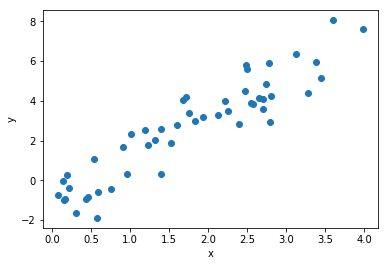

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# plt.rcParams['figure.figsize'] = (10, 5)
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
# y = beta_0_true + beta_1_true * x + epsilon
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_tau(y, x, beta_0, beta_1, alpha, delta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    delta_new = delta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / delta_new)

beta_0   -0.933768
beta_1    2.057191
tau       1.126011
dtype: float64
beta_0    0.242398
beta_1    0.120047
tau       0.217028
dtype: float64


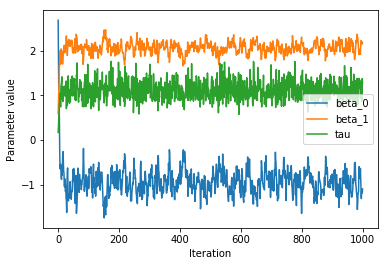

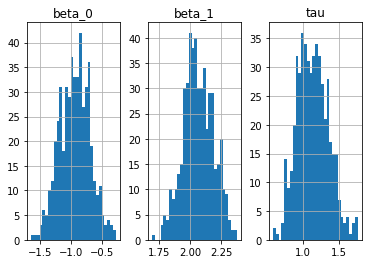

In [2]:
init = {"beta_0": 0, "beta_1": 0, "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,  "tau_0": 1,
          "mu_1": 0,  "tau_1": 1,
          "alpha": 2, "beta": 1}

def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

iters = 1000
trace = gibbs(y, x, iters, init, hypers)

traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

print(trace_burnt.median())
print(trace_burnt.std())